# Recommend Vendors to Agencies
> Recommend vendors to local agencies in Washington DC using cosine similarity on interaction matrix

- toc: true
- badges: true
- comments: true
- categories: [Reference, CosineSimilarity]
- image:

## Setup

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import decomposition
import math

from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import f1_score as f1

In [ ]:
TOP_N_VALS = 20

## EDA

In [ ]:
data = pd.read_csv('Purchase_Card_Transactions.csv')

In [ ]:
data.head()

,OBJECTID,AGENCY,TRANSACTION_DATE,TRANSACTION_AMOUNT,VENDOR_NAME,VENDOR_STATE_PROVINCE,MCC_DESCRIPTION
0,2,Department of Mental Health,2009/01/05 05:00:00+00,229.50,WW GRAINGER 912,DC,"Industrial Supplies, Not Elsewhere Classified"
1,3,District Department of Transportation,2009/01/05 05:00:00+00,3147.33,BRANCH SUPPLY,DC,"Stationery, Office & School Supply Stores"
2,4,Department of Youth Rehabilitation Services,2009/01/05 05:00:00+00,54.00,VIDEO MONITORING SRVCS,NY,Motion Pictures/Video Tape Production&Distribu...
3,5,Office of Employee Appeals,2009/01/05 05:00:00+00,137.35,STAPLES 00102186,DC,"Stationery,Office Supplies,Printing/Writing Paper"
4,6,Office of Police Complaints,2009/01/06 05:00:00+00,1340.80,FAITH MGMT CONSULTING,DC,"Stationery, Office & School Supply Stores"


In [ ]:
data.shape

(433926, 7)

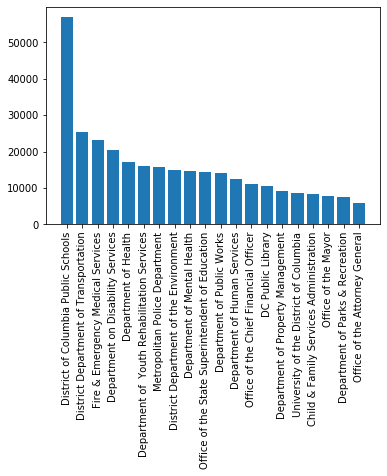

In [ ]:
agencies = dict(data.AGENCY.value_counts()[:TOP_N_VALS])
plt.bar(agencies.keys(), height=agencies.values())
plt.xticks(rotation='vertical')
plt.show()

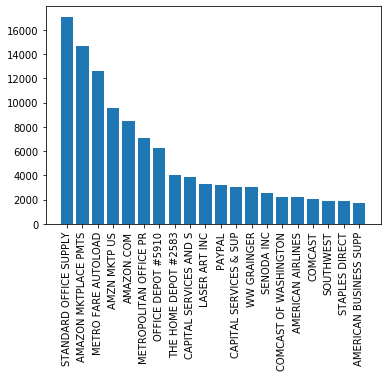

In [ ]:
vendors = dict(data.VENDOR_NAME.value_counts()[:TOP_N_VALS])
plt.bar(vendors.keys(), height=vendors.values())
plt.xticks(rotation='vertical')
plt.show()

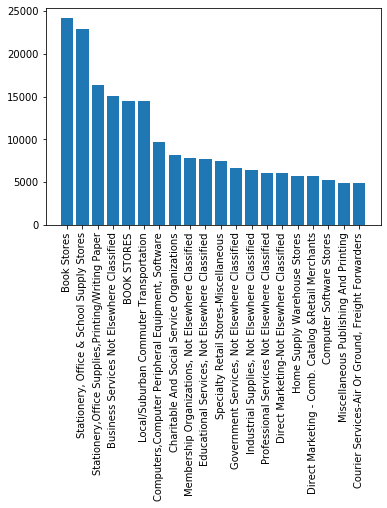

In [ ]:
mcc = dict(data.MCC_DESCRIPTION.value_counts()[:TOP_N_VALS])
plt.bar(mcc.keys(), height=mcc.values())
plt.xticks(rotation='vertical')
plt.show()

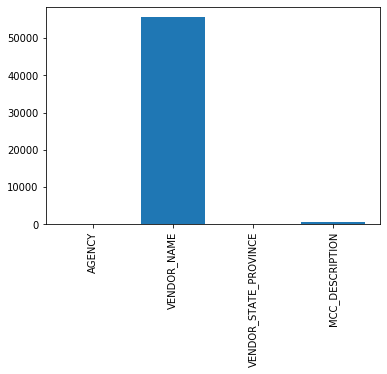

In [ ]:
num_categories = {}
category_cols = ['AGENCY', 'VENDOR_NAME', 'VENDOR_STATE_PROVINCE', 'MCC_DESCRIPTION']
for col in category_cols:
    num_categories[col] = data[col].nunique()
plt.bar(num_categories.keys(), height=num_categories.values())
plt.xticks(rotation='vertical')
plt.show()

(array([3.38727e+05, 4.44950e+04, 2.19660e+04, 4.88000e+03, 4.55000e+03,
        8.95000e+02, 1.54000e+02, 7.90000e+01, 6.80000e+01, 1.30000e+02]),
 array([    0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,  7000.,
         8000.,  9000., 10000.]),
 <a list of 10 Patch objects>)

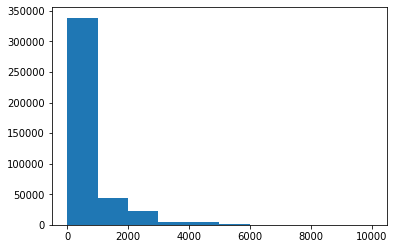

In [ ]:
plt.hist(data.TRANSACTION_AMOUNT, range = (0, 10000))

(array([121074.,  61705.,  40097.,  30216.,  22896.,  19004.,  14172.,
         11732.,   9426.,   9573.]),
 array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000.]),
 <a list of 10 Patch objects>)

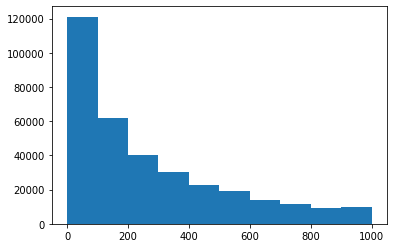

In [ ]:
plt.hist(data.TRANSACTION_AMOUNT, range = (0, 1000))

In [ ]:
data[data.TRANSACTION_AMOUNT < 0]

,OBJECTID,AGENCY,TRANSACTION_DATE,TRANSACTION_AMOUNT,VENDOR_NAME,VENDOR_STATE_PROVINCE,MCC_DESCRIPTION
101,289,Office of Police Complaints,2009/01/08 05:00:00+00,-79.95,CAPITAL SERVICES AND S,DC,Office and Commercial Furniture
187,65,Department of Health,2009/01/06 05:00:00+00,-464.48,PRESSTEK,NH,"Commercial Photography, Art & Graphics"
204,82,Department of Property Management,2009/01/06 05:00:00+00,-608.97,IKEA COLLEGE PARK,MD,"Furniture, Home Furnishings And Equipment Stores"
219,97,District Department of the Environment,2009/01/06 05:00:00+00,-39.66,U-STORE WASHINGTON,DC,"Freight Carriers, Trucking - Local/Long Distance"
227,105,Department of Corrections,2009/01/07 05:00:00+00,-48.62,HMCO ECMMRCE* BOOKS,IL,Direct Marketing-Not Elsewhere Classified
...,...,...,...,...,...,...,...
433868,433869,Department of Human Services,2020/10/27 04:00:00+00,-12.24,"WIX.COM, INC.",CA,COMPUTER SOFTWARE STORES
433895,433896,District Department of Transportation,2020/06/02 04:00:00+00,-1995.00,EB JULY 2020 EXECUTIV,CA,BUSINESS SERVICES-NOT ELSEWHERE CLASSIFIED
433897,433898,Office of Contracting & Procurement,2020/06/03 04:00:00+00,-2160.12,DISPUTE CREDIT,IL,OFFICE SCHOOL SUPPLY AND STATIONERY STORES
433902,433903,District of Columbia Public Schools,2020/06/02 04:00:00+00,-34.44,STAPLES 00115170,MD,OFFICE SCHOOL SUPPLY AND STATIONERY STORES


In [ ]:
data[data.TRANSACTION_AMOUNT > 100000]

,OBJECTID,AGENCY,TRANSACTION_DATE,TRANSACTION_AMOUNT,VENDOR_NAME,VENDOR_STATE_PROVINCE,MCC_DESCRIPTION
112441,112263,Office of Contracting & Procurement,2012/07/17 04:00:00+00,100411.0,FORT MYER CONSTRUCTION,DC,"Genl Contractors-Residential, and Commercial"
129248,129137,Office of Contracting & Procurement,2013/01/08 05:00:00+00,143500.0,JIMMIE MUSCATELLOS,DC,Uniforms and Commercial Clothing
219756,219964,Office of Contracting & Procurement,2016/02/04 05:00:00+00,150247.5,"C.W. STRITTMATTER, INC",VA,"Rentals-Tools, Equipment and Furniture"
219761,219969,Office of Contracting & Procurement,2016/02/04 05:00:00+00,400085.0,"C.W. STRITTMATTER, INC",VA,"Rentals-Tools, Equipment and Furniture"
220836,220805,Office of Contracting & Procurement,2016/02/03 05:00:00+00,124464.0,HURB LANDSCAPING,NY,"Nurseries, Lawn & Garden Supply Stores"
...,...,...,...,...,...,...,...
235531,235567,Office of Contracting & Procurement,2016/03/06 05:00:00+00,233100.0,NORTHEAST SNOWPLOW,CT,Landscaping And Horticultural Services
235532,235568,Office of Contracting & Procurement,2016/03/04 05:00:00+00,274620.0,"C.W. STRITTMATTER, INC",VA,"Rentals-Tools, Equipment and Furniture"
249536,249863,Office of Contracting & Procurement,2016/04/19 04:00:00+00,545197.5,CAPITOL PAVING OF DC I,DC,"Special Trade Contractors,Not Elsewhere Classi..."
249537,249864,Office of Contracting & Procurement,2016/04/20 04:00:00+00,388550.0,CAPITOL PAVING OF DC I,DC,"Special Trade Contractors,Not Elsewhere Classi..."


In [ ]:
set(data.AGENCY.unique()).intersection(data.VENDOR_NAME.unique())

set()

In [ ]:
#hide
data.MCC_DESCRIPTION.unique()

array(['Industrial Supplies, Not Elsewhere Classified',
       'Stationery, Office & School Supply Stores',
       'Motion Pictures/Video Tape Production&Distribution',
       'Stationery,Office Supplies,Printing/Writing Paper',
       'Business Services Not Elsewhere Classified',
       'Professional Services Not Elsewhere Defined',
       'General Merchandise', 'Automobile & Truck Dealer - New & Used',
       'Book Stores',
       'Membership Organizations, Not Elsewhere Classified',
       'Quick-Copy, Reproduction and Blueprinting Services',
       'Computers,Computer Peripheral Equipment, Software',
       'Computer Software Stores', 'Office and Commercial Furniture',
       'Educational Services, Not Elsewhere Classified',
       'Books, Periodicals And Newspapers',
       'Hotels-Lodging (Not Listed Elsewhere)',
       'Specialty Retail Stores-Miscellaneous', 'Hardware Stores',
       'Electrical Contractors', 'Commercial Photography, Art & Graphics',
       'Direct Marketing - 

## Preprocessing

In [ ]:
data[data.VENDOR_STATE_PROVINCE.isna()]

,OBJECTID,AGENCY,TRANSACTION_DATE,TRANSACTION_AMOUNT,VENDOR_NAME,VENDOR_STATE_PROVINCE,MCC_DESCRIPTION
77,265,Fire & Emergency Medical Services,2009/01/09 05:00:00+00,0.42,INTERNATIONAL TRANSACTION,NaN,Unknown
78,266,Fire & Emergency Medical Services,2009/01/09 05:00:00+00,42.36,WWW.NCHSOFTWARE.COM,NaN,Computer Software Stores
864,617,District Department of the Environment,2009/01/13 05:00:00+00,0.82,INTERNATIONAL TRANSACTION,NaN,Unknown
1436,1495,Fire & Emergency Medical Services,2009/01/23 05:00:00+00,0.75,INTERNATIONAL TRANSACTION,NaN,Unknown
1437,1496,Fire & Emergency Medical Services,2009/01/23 05:00:00+00,75.03,WWW.NCHSOFTWARE.COM,NaN,Computer Software Stores
...,...,...,...,...,...,...,...
432044,432158,Department of Mental Health,2020/03/17 04:00:00+00,2301.14,DENTAL IMG DBA ISI/GEN,NaN,DENTAL-LAB-MED-OPHTHALMIC HOSP EQUIP + SUPPLIES
432141,432192,OFFICE OF PEOPLE'S COUNSEL,2020/03/21 04:00:00+00,713.04,CISCO SYSTEMS INC,NaN,ELECTRONIC SALES
432655,432789,Department of Health,2020/03/11 04:00:00+00,2008.12,MORTECH MANUFACTURING,NaN,INDUSTRIAL SUPPLIES NOT ELSEWHERE CLASSIFIED
433457,433360,Department of Public Works,2020/02/21 05:00:00+00,250.00,REMCO BUSIN,NaN,OFFICE AND COMMERCIAL FURNITURE


In [ ]:
data[data.AGENCY.isna()]

,OBJECTID,AGENCY,TRANSACTION_DATE,TRANSACTION_AMOUNT,VENDOR_NAME,VENDOR_STATE_PROVINCE,MCC_DESCRIPTION


In [ ]:
data[data.VENDOR_NAME.isna()]

,OBJECTID,AGENCY,TRANSACTION_DATE,TRANSACTION_AMOUNT,VENDOR_NAME,VENDOR_STATE_PROVINCE,MCC_DESCRIPTION
2031,2032,Department of Human Services,2009/02/04 05:00:00+00,128.98,NaN,NaN,Unknown Vendor
2254,2444,DC Public Library,2009/02/05 05:00:00+00,119.04,NaN,NaN,Unknown Vendor
2259,2449,DC Public Library,2009/02/05 05:00:00+00,222.81,NaN,NaN,Unknown Vendor
2329,2209,Fire & Emergency Medical Services,2009/02/08 05:00:00+00,750.91,NaN,NaN,Unknown Vendor
2331,2211,Fire & Emergency Medical Services,2009/02/07 05:00:00+00,168.37,NaN,NaN,Unknown Vendor
2398,2278,Fire & Emergency Medical Services,2009/02/06 05:00:00+00,355.82,NaN,NaN,Unknown Vendor
2702,2738,Department of Health,2009/02/09 05:00:00+00,210.00,NaN,NaN,Unknown Vendor
2836,2556,Department on Disability Services,2009/02/10 05:00:00+00,148.49,NaN,NaN,Unknown Vendor
2916,2636,Department of Human Services,2009/02/11 05:00:00+00,148.07,NaN,NaN,Unknown Vendor
65511,65940,University of the District of Columbia,2011/02/10 05:00:00+00,1300.00,NaN,NaN,NaN


In [ ]:
data[data.TRANSACTION_AMOUNT.isna()]

,OBJECTID,AGENCY,TRANSACTION_DATE,TRANSACTION_AMOUNT,VENDOR_NAME,VENDOR_STATE_PROVINCE,MCC_DESCRIPTION


In [ ]:
cleaned_data = data[data.VENDOR_NAME.notna()]
cleaned_data = cleaned_data[data.TRANSACTION_AMOUNT >= 0]

In [ ]:
agencies = sorted(cleaned_data.AGENCY.unique())
vendors = sorted(cleaned_data.VENDOR_NAME.unique())
industries = sorted(cleaned_data.MCC_DESCRIPTION.unique())
agency_ids = {}
vendor_ids = {}
industry_ids = {}
for i in range(len(agencies)):
    agency_ids[agencies[i]] = i
for i in range(len(vendors)):
    vendor_ids[vendors[i]] = i
for i in range(len(industries)):
    industry_ids[industries[i]] = i

In [ ]:
cleaned_data['AGENCY_ID'] = [agency_ids[agency] for agency in cleaned_data.AGENCY]
cleaned_data['VENDOR_ID'] = [vendor_ids[vendor] for vendor in cleaned_data.VENDOR_NAME]
cleaned_data['INDUSTRY_ID'] = [industry_ids[industry] for industry in cleaned_data.MCC_DESCRIPTION]

In [ ]:
cleaned_data.to_csv('cleaned_data.csv')

In [ ]:
cleaned_data = cleaned_data[["AGENCY_ID", "TRANSACTION_AMOUNT", "VENDOR_ID"]]

In [ ]:
cleaned_data.head()

,AGENCY_ID,TRANSACTION_AMOUNT,VENDOR_ID
0,34,229.50,54485
1,43,3147.33,9435
2,24,54.00,52842
3,59,137.35,45199
4,67,1340.80,18299


In [ ]:
cleaned_data.shape

(416233, 3)

In [ ]:
def convert_to_matrix(df, rows, cols):
    matrix = [[0 for i in range(len(cols))] for j in range(len(rows))]
    for idx in df.index:
        matrix[idx[0]][idx[1]] = df.loc[idx].TRANSACTION_AMOUNT
    return matrix 

**Average Transactions Matrix**

In [ ]:
means = cleaned_data.groupby(['AGENCY_ID', 'VENDOR_ID']).mean()
means_matrix = convert_to_matrix(means, agency_ids.values(), vendor_ids.values())
means_df = pd.DataFrame(means_matrix)
means_df.to_csv('means.csv')

**Raw Number of Transactions Matrix**

In [ ]:
counts = cleaned_data.groupby(['AGENCY_ID', 'VENDOR_ID']).count()
counts_matrix = convert_to_matrix(counts, agency_ids.values(), vendor_ids.values())
counts_df = pd.DataFrame(counts_matrix)
counts_df.to_csv('counts.csv')

**Sum of Transactions Matrix**

In [ ]:
sums = cleaned_data.groupby(['AGENCY_ID', 'VENDOR_ID']).sum()
sums_matrix = convert_to_matrix(sums, agency_ids.values(), vendor_ids.values())
sums_df = pd.DataFrame(sums_matrix)
sums_df.to_csv('sums.csv')

## Load cleaned data

In [ ]:
data = pd.read_csv('cleaned_data.csv')
data.drop('Unnamed: 0', axis='columns', inplace=True)
data.sort_values(by=['TRANSACTION_DATE'], inplace=True)

## Train/test split

In [ ]:
train = data[:math.floor(.8*len(data))]
test = data[math.floor(.8*len(data)):]

In [ ]:
print(sorted(train.TRANSACTION_DATE.unique())[:3], sorted(train.TRANSACTION_DATE.unique())[-3:])

['2009/01/02 05:00:00+00', '2009/01/03 05:00:00+00', '2009/01/04 05:00:00+00'] ['2018/09/08 04:00:00+00', '2018/09/09 04:00:00+00', '2018/09/10 04:00:00+00']


In [ ]:
print(sorted(test.TRANSACTION_DATE.unique())[:3], sorted(test.TRANSACTION_DATE.unique())[-3:])

['2018/09/10 04:00:00+00', '2018/09/11 04:00:00+00', '2018/09/12 04:00:00+00'] ['2020/10/28 04:00:00+00', '2020/10/29 04:00:00+00', '2020/10/30 04:00:00+00']


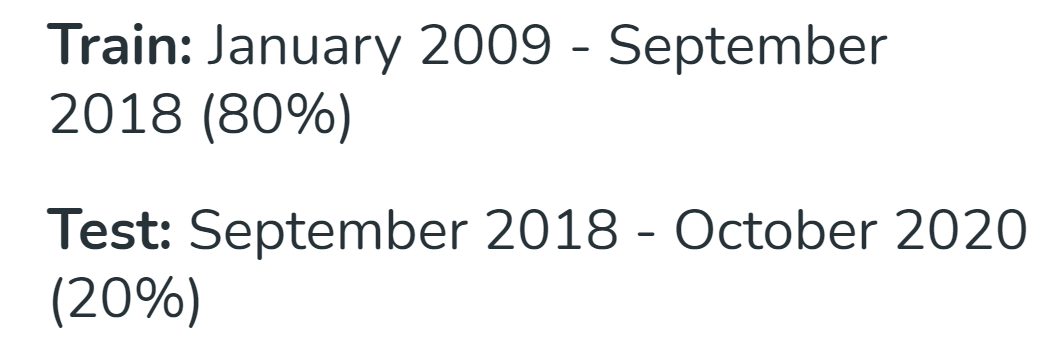

## Convert to matrix

In [ ]:
agencies = sorted(data.AGENCY.unique())
vendors = sorted(data.VENDOR_NAME.unique())
agency_ids = {}
vendor_ids = {}
for i in range(len(agencies)):
    agency_ids[agencies[i]] = i
for i in range(len(vendors)):
    vendor_ids[vendors[i]] = i

In [ ]:
train = train[["AGENCY_ID", "TRANSACTION_AMOUNT", "VENDOR_ID"]]
test = test[["AGENCY_ID", "TRANSACTION_AMOUNT", "VENDOR_ID"]]

In [ ]:
def convert_to_matrix(df, rows, cols):
    matrix = [[0 for i in range(len(cols))] for j in range(len(rows))]
    for idx in df.index:
        matrix[idx[0]][idx[1]] = df.loc[idx].TRANSACTION_AMOUNT
    return matrix 

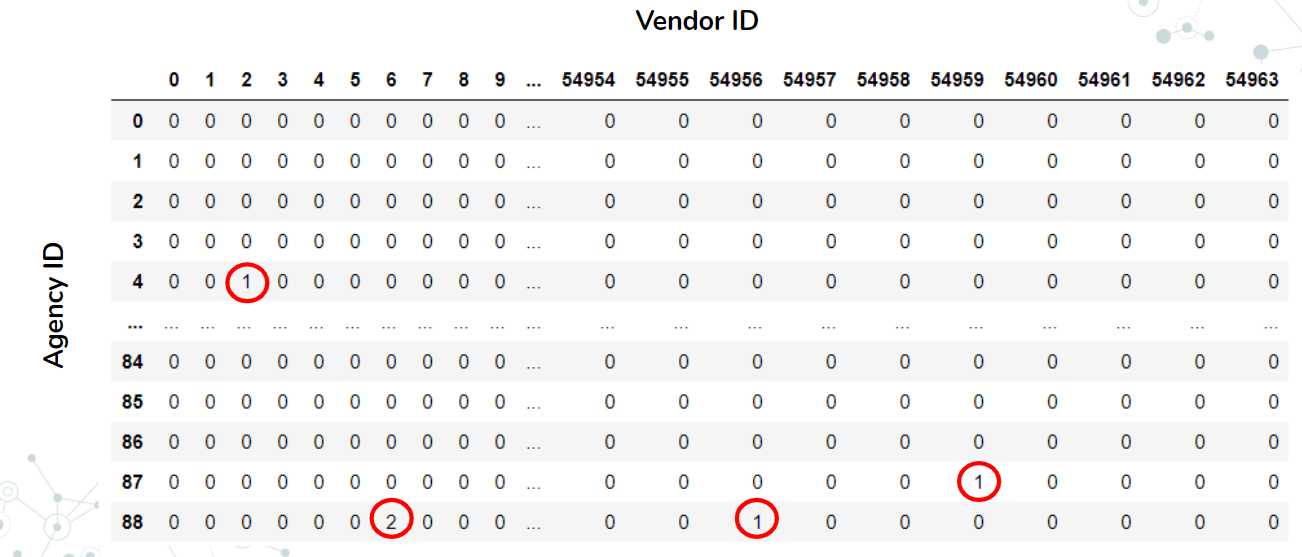

In [ ]:
counts = train.groupby(['AGENCY_ID', 'VENDOR_ID']).count()
train_counts = pd.DataFrame(convert_to_matrix(counts, agency_ids.values(), vendor_ids.values()))

In [ ]:
counts = test.groupby(['AGENCY_ID', 'VENDOR_ID']).count()
test_counts = pd.DataFrame(convert_to_matrix(counts, agency_ids.values(), vendor_ids.values()))

## Making recommendations

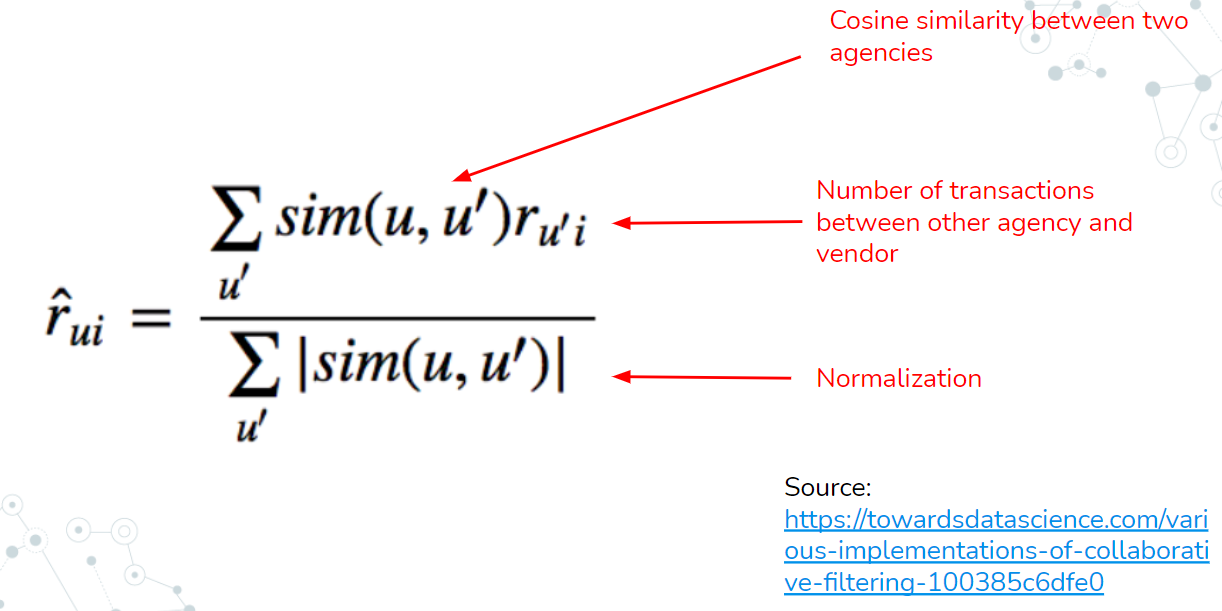

In [ ]:
cos_counts = cosine_similarity(train_counts)

In [ ]:
pd.DataFrame(cos_counts)

,0,1,2,3,4,5,6,7,8,9,...,79,80,81,82,83,84,85,86,87,88
0,1.000000,0.068136,0.080668,0.526835,0.151007,0.526983,0.569407,0.020808,0.105257,0.534175,...,0.774991,0.502050,0.011826,0.672543,0.010237,0.640565,0.176044,0.442245,0.225285,0.319560
1,0.068136,1.000000,0.158139,0.294187,0.372166,0.510850,0.064115,0.474408,0.055798,0.120816,...,0.169362,0.222992,0.050724,0.074396,0.072682,0.127038,0.143595,0.381923,0.139603,0.264789
2,0.080668,0.158139,1.000000,0.125748,0.179328,0.204949,0.046233,0.246575,0.152228,0.102740,...,0.159157,0.273899,0.058661,0.189571,0.105481,0.100539,0.070347,0.162186,0.207033,0.233579
3,0.526835,0.294187,0.125748,1.000000,0.261977,0.656689,0.422708,0.374770,0.256287,0.541998,...,0.596516,0.416764,0.043146,0.464330,0.029044,0.703732,0.148270,0.492929,0.199174,0.323473
4,0.151007,0.372166,0.179328,0.261977,1.000000,0.385737,0.114777,0.293952,0.178592,0.225322,...,0.237978,0.362104,0.058102,0.208130,0.109644,0.171217,0.245557,0.306668,0.241813,0.304033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,0.640565,0.127038,0.100539,0.703732,0.171217,0.478623,0.495655,0.131515,0.208365,0.556791,...,0.678639,0.507929,0.040272,0.597604,0.029198,1.000000,0.203210,0.379443,0.240190,0.303012
85,0.176044,0.143595,0.070347,0.148270,0.245557,0.195494,0.131094,0.030165,0.125298,0.180897,...,0.203593,0.260311,0.047700,0.178449,0.032980,0.203210,1.000000,0.134023,0.110448,0.242836
86,0.442245,0.381923,0.162186,0.492929,0.306668,0.652391,0.337213,0.381603,0.040144,0.343984,...,0.580623,0.443149,0.016636,0.422888,0.056162,0.379443,0.134023,1.000000,0.268236,0.389996
87,0.225285,0.139603,0.207033,0.199174,0.241813,0.249273,0.215142,0.175016,0.189289,0.187817,...,0.317581,0.502760,0.063515,0.356430,0.101448,0.240190,0.110448,0.268236,1.000000,0.309487


In [ ]:
def make_recommendations(transactions, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(transactions) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [ ]:
np_train_counts = train_counts.to_numpy()

In [ ]:
recommendations = make_recommendations(np_train_counts, cos_counts)

In [ ]:
for i in range(len(recommendations)): 
    for j in range(len(recommendations[i])): 
        recommendations[i][j]/=4

In [ ]:
def get_mae(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mae(pred, actual)

In [ ]:
np_test_counts = test_counts.to_numpy()

In [ ]:
nonzero_mae = get_mae(recommendations, np_test_counts)
full_mae = mae(recommendations, np_test_counts)

In [ ]:
full_mae

0.0329789789723071

## References
1. https://github.com/vinaytummarakota/datathon-2021 `code`
2. https://docs.google.com/presentation/d/1zQbqXUQDL26hPcwlVOvDa6cKGqFDV_LaBGqTJNh3JqE/edit#slide=id.gbb5bc7b637_0_290 `ppt`